<a href="https://colab.research.google.com/github/nicolai5965/Transformer_scratch_tensorflow/blob/main/Transformer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import string
import re
import time
import warnings
import pickle
import pytz
import datetime
import os

# Import Natural Language Toolkit and download required corpora
from nltk.corpus import words
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('words')
nltk.download('punkt')

# Import Tensorflow and Keras related libraries
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import deserialize as deserialize_layer

# Import sklearn for data splitting
from sklearn.model_selection import train_test_split

# Import Google Colab library for Google Drive integration
from google.colab import drive
# Mount Google Drive to load the dataset
drive.mount('/content/drive')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [ ]:
# Define the file path and load the train and test data
filepath = '/content/drive/My Drive/Colab Notebooks/Machine Learning/TensorFlow/GRU/'

# Load the dataset into a pandas dataframe
df = pd.read_csv(f'{filepath}fake_or_real_news.csv')

In [ ]:
# Display the dataframe for visual inspection
#display(df)

# Data preparation

In [ ]:
class TextPreprocessor:
    # Initialize TextPreprocessor with remove strings, fraction, and column name
    def __init__(self, strings_to_remove, fraction, column_name):
        self.strings_to_remove = strings_to_remove
        self.fraction = fraction
        self.column_name = column_name

    # Function to remove specific strings from the text
    def _remove_strings(self, text):
        for string in self.strings_to_remove:
            text = text.replace(string, ' ')
        # Remove URLs and user handles
        text = re.sub(r'http\S+|www.\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\(@\w+\)', '', text)
        return text.lower()

    # Preprocesses a dataframe, removing strings and sampling a subset of it
    def preprocess(self, df):
        df_shuffled = df.sample(frac=1).reset_index(drop=True)
        num_samples = int(len(df_shuffled) * self.fraction)
        df_subset = df_shuffled[:num_samples].copy()

        df_subset[self.column_name] = df_subset[self.column_name].apply(self._remove_strings)
        return df_subset[self.column_name].values


class TextTokenizer:
    # Initialize the tokenizer
    def __init__(self):
        self.tokenizer = Tokenizer()

    # Fit the tokenizer to the texts and add Start and End of Sentence tokens
    def fit(self, texts):
        self.tokenizer.fit_on_texts(texts)
        self.tokenizer.word_index['<SOS>'] = len(self.tokenizer.word_index) + 1
        self.tokenizer.word_index['<EOS>'] = len(self.tokenizer.word_index) + 1

    # Tokenize the texts
    def tokenize(self, texts):
        return [self._custom_tokenize_text(t) for t in texts]

    # Convert texts to sequences
    def texts_to_sequences(self, texts):
        return self.tokenizer.texts_to_sequences(texts)

    # Custom tokenize text method that also retains punctuation
    def _custom_tokenize_text(self, text):
        return re.findall(r'\b\w+\b|[' + string.punctuation + ']', text)

    # Getter method for word index
    @property
    def word_index(self):
        return self.tokenizer.word_index

    # Getter method for index word
    @property
    def index_word(self):
        return self.tokenizer.index_word


class PadToFixed:
    # Initialize the class with max sequence length
    def __init__(self, max_sequence_len):
        self.max_sequence_len = max_sequence_len

    # Fit and transform the sequences to fixed length
    def fit_transform(self, encoder_sequences, decoder_sequences, decoder_labels):
        return self._pad_to_fixed(encoder_sequences, decoder_sequences, decoder_labels)

    # Pad sequences to a fixed length
    def _pad_to_fixed(self, encoder_sequences, decoder_sequences, decoder_labels):
        encoder_sequences = tf.keras.preprocessing.sequence.pad_sequences(encoder_sequences, padding='post', maxlen=self.max_sequence_len)
        decoder_sequences = tf.keras.preprocessing.sequence.pad_sequences(decoder_sequences, padding='post', maxlen=self.max_sequence_len)
        decoder_labels = tf.keras.preprocessing.sequence.pad_sequences(decoder_labels, padding='post', maxlen=self.max_sequence_len)
        return encoder_sequences, decoder_sequences, decoder_labels


class SequenceTokenizer:
    # Initialize SequenceTokenizer with a tokenizer
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    # Add Start and End of Sentence tokens to sequences
    def add_SOS_EOS_tokens(self, sequences):
        encoder_sequences = [[self.tokenizer.word_index['<SOS>']] + seq + [self.tokenizer.word_index['<EOS>']] for seq in sequences]
        decoder_sequences = [[self.tokenizer.word_index['<SOS>']] + seq[1:] for seq in sequences]
        decoder_labels = [seq[1:] + [self.tokenizer.word_index['<EOS>']] for seq in sequences]
        return encoder_sequences, decoder_sequences, decoder_labels

In [ ]:
class DataInformation:
    # Initialize the DataInformation class with training and validation data
    def __init__(self,
                 train_encoder_inputs,
                 train_decoder_inputs,
                 train_decoder_labels,
                 val_encoder_inputs,
                 val_decoder_inputs,
                 val_decoder_labels):

        self.train_encoder_inputs = train_encoder_inputs
        self.train_decoder_inputs = train_decoder_inputs
        self.train_decoder_labels = train_decoder_labels
        self.val_encoder_inputs = val_encoder_inputs
        self.val_decoder_inputs = val_decoder_inputs
        self.val_decoder_labels = val_decoder_labels

    # Method to display the shape and size information about the data
    def display_info(self):
        # Preparing data to show sequence shapes
        data_sequence_shapes = {
            'Train Encoder Input Shape': [self.train_encoder_inputs.shape],
            'Train Decoder Input Shape': [self.train_decoder_inputs.shape],
            'Train Decoder Label Shape': [self.train_decoder_labels.shape],
            'Val Encoder Input Shape': [self.val_encoder_inputs.shape],
            'Val Decoder Input Shape': [self.val_decoder_inputs.shape],
            'Val Decoder Label Shape': [self.val_decoder_labels.shape],
        }

        # Create a dataframe and display it
        df_sequence_shapes = pd.DataFrame(data_sequence_shapes)

        # Preparing data to show dataset information
        data_dataset = {
            'Dataset': ['Train Encoder Input', 'Train Decoder Input', 'Train Decoder Label',
                        'Val Encoder Input', 'Val Decoder Input', 'Val Decoder Label'],
            'Total Tokens': [len(self.train_encoder_inputs), len(self.train_decoder_inputs),
                             len(self.train_decoder_labels), len(self.val_encoder_inputs),
                             len(self.val_decoder_inputs), len(self.val_decoder_labels)],
            'Total Parameters': [self.train_encoder_inputs.size, self.train_decoder_inputs.size,
                                 self.train_decoder_labels.size, self.val_encoder_inputs.size,
                                 self.val_decoder_inputs.size, self.val_decoder_labels.size]
        }

        # Create a dataframe and display it
        df_dataset = pd.DataFrame(data_dataset)

        print("Sequence Shapes:")
        display(df_sequence_shapes)

        print("Dataset Information:")
        display(df_dataset)


In [ ]:
class DataPreprocessor:
    # Initialize the DataPreprocessor class with configuration and verbosity settings
    def __init__(self, config, verbose_1=True, verbose_2=True):
        self.config = config
        self.verbose_1 = verbose_1
        self.verbose_2 = verbose_2

        # Setup preprocessors and tokenizers
        self.preprocessor = TextPreprocessor(
            strings_to_remove=self.config['strings_to_remove'],
            fraction=self.config['data_proportion'],
            column_name=self.config['column_name']
        )
        self.tokenizer = TextTokenizer()
        self.sequence_tokenizer = SequenceTokenizer(self.tokenizer)
        self.pad_to_fixed = PadToFixed(max_sequence_len=self.config['max_sequence_len'])

    # Main method to preprocess data
    def preprocess(self):
        # Apply preprocessing and sentence tokenization
        text = self.preprocessor.preprocess(self.config['dataframe'])
        text = [sent_tokenize(t) for t in text]
        text = [sent for article in text for sent in article]

        # Split data into training and validation sets
        train_text, val_text = train_test_split(
            text,
            test_size=self.config['val_split_size'],
            random_state=42
        )

        # Fit tokenizer on training data and tokenize both training and validation data
        self.tokenizer.fit(train_text)
        train_tokens = self.tokenizer.tokenize(train_text)
        val_tokens = self.tokenizer.tokenize(val_text)

        total_words = sum([len(t) for t in train_tokens])

        # Add Start and End of Sentence tokens and pad sequences to fixed length
        encoder_sequences_train, decoder_sequences_train, decoder_labels_train = self.sequence_tokenizer.add_SOS_EOS_tokens(
            self.tokenizer.texts_to_sequences(train_tokens)
        )
        encoder_sequences_val, decoder_sequences_val, decoder_labels_val = self.sequence_tokenizer.add_SOS_EOS_tokens(
            self.tokenizer.texts_to_sequences(val_tokens)
        )

        encoder_input_train, decoder_input_train, decoder_target_train = self.pad_to_fixed.fit_transform(
            encoder_sequences_train,
            decoder_sequences_train,
            decoder_labels_train
        )
        encoder_input_val, decoder_input_val, decoder_target_val = self.pad_to_fixed.fit_transform(
            encoder_sequences_val,
            decoder_sequences_val,
            decoder_labels_val
        )

        # Display information about the data if verbosity is set
        if self.verbose_1:
            data_info = DataInformation(
                encoder_input_train,
                decoder_input_train,
                decoder_target_train,
                encoder_input_val,
                decoder_input_val,
                decoder_target_val
            )
            data_info.display_info()

        # Create TensorFlow datasets for training and validation
        train_dataset = tf.data.Dataset.from_tensor_slices(
            (encoder_input_train, decoder_input_train, decoder_target_train)
        )
        val_dataset = tf.data.Dataset.from_tensor_slices(
            (encoder_input_val, decoder_input_val, decoder_target_val)
        )

        # Shuffle training data and batch both datasets
        train_dataset = train_dataset.shuffle(self.config['BUFFER_SIZE']).batch(
            self.config['BATCH_SIZE'],
            drop_remainder=False
        )
        val_dataset = val_dataset.batch(
            self.config['BATCH_SIZE'],
            drop_remainder=False
        )  # Note: No need to shuffle the validation data

        # Return datasets, vocab size and the tokenizer
        return train_dataset, val_dataset, len(self.tokenizer.word_index) + 1, self.tokenizer

    # Method to retrieve max sequence length from configuration
    def get_max_sequence_lengths(self):
        return self.config['max_sequence_len'], self.config['max_sequence_len']

# EmbeddingLayer and PositionalEncoding

In [ ]:
class EmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, training=True, verbose=False, name="my_embedding_layer", **kwargs):
        super(EmbeddingLayer, self).__init__(name=name, **kwargs)
        # Store the provided parameters
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.training = training
        self.verbose = verbose

        # Initialize the embedding matrix
        self.embedding_matrix = self.add_weight(name="embedding_matrix", shape=[vocab_size, d_model], initializer='random_normal', trainable=self.training)


    # Define the behavior of the layer during the forward pass
    def call(self, inputs):
        # Lookup the corresponding embedding vectors for each input.
        embeddings = tf.nn.embedding_lookup(self.embedding_matrix, inputs)
        # Multiply embeddings by sqrt of d_model
        embeddings *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        # If verbose, print the shape of the embeddings
        if self.verbose:
            print(f"Embeddings shape: {embeddings.shape}")
        return embeddings

    # Specify the config for this layer
    def get_config(self):
        config = super().get_config()
        config.update({
            'vocab_size': self.vocab_size,
            'd_model': self.d_model,
            'training': self.training,
            'verbose': self.verbose
        })
        return config

    # Define how to recreate the layer from its config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
# PositionalEncoding is a custom layer to add positional encoding to the input
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, name="positional_encoding", **kwargs):
        super(PositionalEncoding, self).__init__(name=name, **kwargs)
        # Store the provided parameters
        self.position = position
        self.d_model = d_model

        # Calculate the positional encodings
        self.pos_encoding = self.calculate_positional_encoding()

    def calculate_positional_encoding(self):
        # Get the angle rates for the positions
        angle_rads = self.get_angles(
            np.arange(self.position)[:, np.newaxis],
            np.arange(self.d_model)[np.newaxis, :],
            self.d_model
        )

        # Apply sin to even indices, cos to odd indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        # Expand dimensions of positional encodings and cast to appropriate type
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    # Method to calculate the angle rates
    @staticmethod
    def get_angles(pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    # Define the behavior of the layer during the forward pass
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    # Specify the config for this layer
    def get_config(self):
        config = super().get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

    # Define how to recreate the layer from its config
    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Setting up the masks

In [ ]:
# Define a class for creating masks
class MaskCreator:
    def __init__(self, identifier=None):
        self.identifier = identifier

        # Layer for creating padding mask from input sequence
        self.padding_mask_layer = tf.keras.layers.Lambda(
            lambda x: tf.cast(tf.math.equal(x, 0), tf.float32),
            name=f"padding_mask_{self.identifier}"
        )

        # Layer for expanding the dimensions of the padding mask
        self.padding_mask_expanded_layer = tf.keras.layers.Lambda(
            lambda x: x[:, tf.newaxis, tf.newaxis, :],
            name=f"padding_mask_expanded_{self.identifier}"
        )

        # Layer for creating a matrix of ones (used for look-ahead mask)
        self.look_ahead_mask_ones_matrix_layer = tf.keras.layers.Lambda(
            lambda x: tf.ones((x, x)),
            name="look_ahead_mask_ones_matrix"
        )

        # Layer for creating look-ahead mask from ones matrix
        self.look_ahead_mask_layer = tf.keras.layers.Lambda(
            lambda x: 1 - tf.linalg.band_part(x, -1, 0),
            name="look_ahead_mask"
        )

    # Method for creating a padding mask
    def create_padding_mask(self, seq):
        seq = self.padding_mask_layer(seq)
        return self.padding_mask_expanded_layer(seq)

    # Method for creating a look-ahead mask
    def create_look_ahead_mask(self, size):
        ones_matrix = self.look_ahead_mask_ones_matrix_layer(size)
        return self.look_ahead_mask_layer(ones_matrix)

# MultiHeadAttention and PointWiseFeedForwardNetwork

In [ ]:
# Define a class for the scaled dot product attention mechanism
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)
        # Layer for calculating matrix multiplication of Q and K, transposing K
        self.matmul_qk_layer = tf.keras.layers.Lambda(
            lambda x: tf.matmul(x[0], x[1], transpose_b=True),
            name="matmul_qk"
        )

        # Layer for finding the depth (last dimension) of the input tensor
        self.depth_layer = tf.keras.layers.Lambda(
            lambda x: tf.cast(tf.shape(x)[-1], tf.float32),
            name="depth"
        )

        # Layer for calculating scaled logits
        self.logits_layer = tf.keras.layers.Lambda(
            lambda x: x[0] / tf.math.sqrt(x[1]),
            name="logits"
        )

        # Layer for applying mask to logits (if mask is provided)
        self.logits_masked_layer = tf.keras.layers.Lambda(
            lambda x: x[0] + (x[1] * -1e9),
            name="logits_masked"
        )

        # Layer for applying softmax to get attention weights
        self.attention_weights_layer = tf.keras.layers.Lambda(
            lambda x: tf.nn.softmax(x, axis=-1),
            name="attention_weights"
        )

        # Layer for calculating the final output
        self.output_layer = tf.keras.layers.Lambda(
            lambda x: tf.matmul(x[0], x[1]),
            name="output"
        )

    # Define the method for the forward pass
    def call(self, q, k, v, mask=None):
        matmul_qk = self.matmul_qk_layer([q, k])
        depth = self.depth_layer(k)
        logits = self.logits_layer([matmul_qk, depth])

        # Apply mask to logits if mask is provided
        if mask is not None:
            logits = self.logits_masked_layer([logits, mask])

        attention_weights = self.attention_weights_layer(logits)
        output = self.output_layer([attention_weights, v])

        return output, attention_weights

In [ ]:
class MultiHeadAttention(Layer):
    def __init__(self, d_model, num_attention_heads, name="multi_head_attention", **kwargs):
        super(MultiHeadAttention, self).__init__(name=name, **kwargs)
        self.num_attention_heads = num_attention_heads
        self.d_model = d_model
        self.scaled_dot_product_attention = ScaledDotProductAttention()

        self.depth = d_model // self.num_attention_heads  # Calculate depth for each head

        # Initializing linear transformation layers
        self.query_lin = tf.keras.layers.Dense(d_model, name=name+"_query_lin")  # Linear transformation layer for queries
        self.key_lin = tf.keras.layers.Dense(d_model, name=name+"_key_lin")  # Linear transformation layer for keys
        self.value_lin = tf.keras.layers.Dense(d_model, name=name+"_value_lin")  # Linear transformation layer for values

        self.final_lin = tf.keras.layers.Dense(d_model, name=name+"_final_lin")  # Linear transformation layer for final output

    # Function to split input into multiple heads
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_attention_heads, self.depth))  # Reshape input tensor to split the last dimension
        return tf.transpose(x, perm=[0, 2, 1, 3])  # Transpose the tensor dimensions

    # Function for forward propagation
    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]  # Get the batch size

        # Apply linear transformations
        W_q = self.query_lin(q)  # Linear transformation for queries
        W_k = self.key_lin(k)  # Linear transformation for keys
        W_v = self.value_lin(v)  # Linear transformation for values

        # Apply scaled dot product attention
        q_split = self.split_heads(W_q, batch_size)  # Split queries into multiple heads
        k_split = self.split_heads(W_k, batch_size)  # Split keys into multiple heads
        v_split = self.split_heads(W_v, batch_size)  # Split values into multiple heads

        scaled_attention, attention_weights = self.scaled_dot_product_attention(
            q_split, k_split, v_split, mask)  # Call to scaled dot product attention layer

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # Transpose attention output

        # Reshape and apply final linear transformation
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))
        output = self.final_lin(concat_attention)

        return output, attention_weights

    # Function to get layer's configuration
    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_attention_heads': self.num_attention_heads,
            'name': self.name,
        })
        return config

    # Classmethod to create layer from its config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
class PointWiseFeedForwardNetwork(tf.keras.layers.Layer):
    # Initialize the layer
    def __init__(self, d_model, dim_ff, identifier, **kwargs):
        super(PointWiseFeedForwardNetwork, self).__init__(**kwargs)

        # Dimensions of model and feed-forward layer, identifier for naming
        self.d_model = d_model
        self.dim_ff = dim_ff
        self.identifier = identifier

        # First layer is dense with ReLU activation
        self.layer1 = tf.keras.layers.Dense(
            dim_ff,
            activation='relu',
            name=f'feed_forward_relu_{identifier}'
        )
        # Second layer is a dense layer for output
        self.layer2 = tf.keras.layers.Dense(
            d_model,
            name=f'feed_forward_output_{identifier}'
        )

    # Method for passing inputs through the network
    def call(self, x):
        x = self.layer1(x)
        return self.layer2(x)

    # Method for saving the configuration of the network
    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'dim_ff': self.dim_ff,
            'identifier': self.identifier,
        })
        return config

    # Class method to create a new network from a configuration
    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [ ]:
class NormAndAdd(tf.keras.layers.Layer):
    # Initialize the layer
    def __init__(self, layernorm, **kwargs):
        super(NormAndAdd, self).__init__(**kwargs)
        # The layer normalization operation to be used
        self.layernorm = layernorm

    # Method to call the layer and perform normalization and addition
    def call(self, inputs):
        return self.layernorm(inputs[0] + inputs[1])

    # Method for saving the configuration of the layer
    def get_config(self):
        config = super(NormAndAdd, self).get_config()
        config.update({
            'layernorm': {
                'class_name': self.layernorm.__class__.__name__,
                'config': self.layernorm.get_config(),
            },
        })
        return config

    # Class method to create a new layer from a configuration
    @classmethod
    def from_config(cls, config):
        layernorm_config = config.pop('layernorm')
        layernorm_class = tf.keras.layers.deserialize(layernorm_config)
        return cls(layernorm=layernorm_class, **config)

# Encoder and Decoder

In [ ]:
# Defining the Encoder Layer of the model
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_attention_heads,
            dim_ff, rate=0.1, name='encoder_layer',
            mha=None, ffn=None,
            norm_and_add1=None, norm_and_add2=None,
            **kwargs):
        super(EncoderLayer, self).__init__(name=name, **kwargs)

        # Initialize layer variables
        self.d_model = d_model
        self.num_attention_heads = num_attention_heads
        self.dim_ff = dim_ff
        self.rate = rate

        # Multi-head attention and pointwise feed forward network
        self.mha = MultiHeadAttention(
            d_model,
            num_attention_heads,
            name='MHA_encoder'
        ) if mha is None else mha

        self.ffn = PointWiseFeedForwardNetwork(
            d_model,
            dim_ff,
            'encoder'
        ) if ffn is None else ffn

        # Normalization and addition layers
        self.norm_and_add1 = NormAndAdd(
            tf.keras.layers.LayerNormalization(epsilon=1e-6),
            name='encoder_NaA_1'
        ) if norm_and_add1 is None else norm_and_add1

        self.norm_and_add2 = NormAndAdd(
            tf.keras.layers.LayerNormalization(epsilon=1e-6),
            name='encoder_NaA_2'
        ) if norm_and_add2 is None else norm_and_add2

        # Dropout layers for regularization
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    # Forward pass for the encoder layer
    def call(self, x, training, padding_mask):
        attn_output, attn_weights = self.mha(x, x, x, padding_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm_and_add1([x, attn_output])  # Normalization and addition

        ffn_output = self.ffn(out1)  # Feed forward network
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.norm_and_add2([out1, ffn_output])  # Normalization and addition

        return out2  # Output of the encoder layer

    # Method to get the configuration of the layer
    def get_config(self):
        config = super().get_config()
        # Adding custom configurations to the config
        config.update({
            'd_model': self.d_model,
            'num_attention_heads': self.num_attention_heads,
            'dim_ff': self.dim_ff,
            'rate': self.rate,
            'name': self.name,
            'mha': {
                'class_name': self.mha.__class__.__name__,
                'config': self.mha.get_config(),
            },
            'ffn': {
                'class_name': self.ffn.__class__.__name__,
                'config': self.ffn.get_config(),
            },
            'norm_and_add1': {
                'class_name': self.norm_and_add1.__class__.__name__,
                'config': self.norm_and_add1.get_config(),
            },
            'norm_and_add2': {
                'class_name': self.norm_and_add2.__class__.__name__,
                'config': self.norm_and_add2.get_config(),
            },
        })
        return config

    # Class method to restore from a configuration
    @classmethod
    def from_config(cls, config):
        # Deserialize each sub-layer from the config
        config['mha'] = deserialize_layer(config['mha'])
        config['ffn'] = deserialize_layer(config['ffn'])
        config['norm_and_add1'] = deserialize_layer(config['norm_and_add1'])
        config['norm_and_add2'] = deserialize_layer(config['norm_and_add2'])
        return cls(**config)

In [ ]:
# Define a custom layer: the Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    # Initialize the Decoder Layer
    def __init__(self, d_model, num_attention_heads, dim_ff, rate=0.1,
                 name='decoder_layer', mha1=None, mha2=None, ffn=None,
                 norm_and_add1=None, norm_and_add2=None, norm_and_add3=None, **kwargs):
        super(DecoderLayer, self).__init__(name=name, **kwargs)

        # Define layer parameters
        self.d_model = d_model
        self.num_attention_heads = num_attention_heads
        self.dim_ff = dim_ff
        self.rate = rate

        # Define the MultiHeadAttention and PointWiseFeedForwardNetwork layers
        self.mha1 = MultiHeadAttention(
            d_model, num_attention_heads, name='MHA_decoder_1'
        ) if mha1 is None else mha1

        self.mha2 = MultiHeadAttention(
            d_model, num_attention_heads, name='MHA_decoder_2'
        ) if mha2 is None else mha2

        self.ffn = PointWiseFeedForwardNetwork(
            d_model, dim_ff, 'decoder'
        ) if ffn is None else ffn

        # Define the Normalization and Addition layers
        self.norm_and_add1 = NormAndAdd(
            tf.keras.layers.LayerNormalization(epsilon=1e-6),
            name='decoder_NaA_1'
        ) if norm_and_add1 is None else norm_and_add1

        self.norm_and_add2 = NormAndAdd(
            tf.keras.layers.LayerNormalization(epsilon=1e-6),
            name='decoder_NaA_2'
        ) if norm_and_add2 is None else norm_and_add2

        self.norm_and_add3 = NormAndAdd(
            tf.keras.layers.LayerNormalization(epsilon=1e-6),
            name='decoder_NaA_3'
        ) if norm_and_add3 is None else norm_and_add3

        # Define the Dropout layers
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    # Define the call function for the layer
    def call(self, dec_input, enc_output, training, look_ahead_mask, dec_padding_mask, enc_padding_mask):
        # Create a combined mask from look_ahead and decoder padding masks
        combined_mask = tf.keras.layers.Lambda(
            lambda x: tf.maximum(x[0], x[1]), name="mask_combiner"
        )([look_ahead_mask, dec_padding_mask])

        # Call MHA1 and apply dropout and normalization
        attn1, attn_weights_block1 = self.mha1(
            dec_input, dec_input, dec_input, combined_mask
        )
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.norm_and_add1([attn1, dec_input])

        # Call MHA2 with encoder output and apply dropout and normalization
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, enc_padding_mask
        )
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.norm_and_add2([attn2, out1])

        # Apply pointwise feed-forward network and dropout, then normalize and add
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.norm_and_add3([ffn_output, out2])

        # Return the final output
        return out3

    # Config function to get layer configuration
    def get_config(self):
        config = super().get_config()
        config.update({
            # Add custom configurations
            'd_model': self.d_model,
            'num_attention_heads': self.num_attention_heads,
            'dim_ff': self.dim_ff,
            'rate': self.rate,
            'name': self.name,
            # Serialize sub-layers
            'mha1': {
                'class_name': self.mha1.__class__.__name__,
                'config': self.mha1.get_config(),
            },
            'mha2': {
                'class_name': self.mha2.__class__.__name__,
                'config': self.mha2.get_config(),
            },
            'ffn': {
                'class_name': self.ffn.__class__.__name__,
                'config': self.ffn.get_config(),
            },
            'norm_and_add1': {
                'class_name': self.norm_and_add1.__class__.__name__,
                'config': self.norm_and_add1.get_config(),
            },
            'norm_and_add2': {
                'class_name': self.norm_and_add2.__class__.__name__,
                'config': self.norm_and_add2.get_config(),
            },
            'norm_and_add3': {
                'class_name': self.norm_and_add3.__class__.__name__,
                'config': self.norm_and_add3.get_config(),
            },
        })
        return config

    # Method to restore from a configuration
    @classmethod
    def from_config(cls, config):
        # Deserialize each sub-layer
        config['mha1'] = deserialize_layer(config['mha1'])
        config['mha2'] = deserialize_layer(config['mha2'])
        config['ffn'] = deserialize_layer(config['ffn'])
        config['norm_and_add1'] = deserialize_layer(config['norm_and_add1'])
        config['norm_and_add2'] = deserialize_layer(config['norm_and_add2'])
        config['norm_and_add3'] = deserialize_layer(config['norm_and_add3'])
        return cls(**config)

In [ ]:
class Encoder(tf.keras.layers.Layer):
    # Initializer for the Encoder class.
    def __init__(self, num_layers, d_model,
            num_attention_heads, dim_ff, input_vocab_size,
            max_position, rate=0.1, name='Encoder_Block',
            embedding_layer=None, pos_encoding_layer=None,
            encoder_layers=None, dropout=None, **kwargs
        ):
        super(Encoder, self).__init__(name=name, **kwargs)

        # Store all initial parameters
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_attention_heads = num_attention_heads
        self.dim_ff = dim_ff
        self.input_vocab_size = input_vocab_size
        self.max_position = max_position
        self.rate = rate

        # Creating an embedding layer if not provided
        if embedding_layer is None:
            self.embedding_layer = EmbeddingLayer(
                input_vocab_size,
                d_model,
                name='encoder_embedding',
                trainable=True
            )
        else:
            self.embedding_layer = embedding_layer

        # Creating a positional encoding if not provided
        if pos_encoding_layer is None:
            self.pos_encoding = PositionalEncoding(
                max_position,
                d_model,
                name='encoder_encoding'
            )
        else:
            self.pos_encoding = pos_encoding_layer

        # Creating encoder layers if not provided
        if encoder_layers is None:
            self.enc_layers = [
                EncoderLayer(
                    d_model,
                    num_attention_heads,
                    dim_ff,
                    rate,
                    name=f"encoder_layer_{i+1}"
                ) for i in range(num_layers)
            ]
        else:
            self.enc_layers = encoder_layers

        #self.dropout = tf.keras.layers.Dropout(rate)

        # Creating a dropout layer if not provided
        if dropout is None:
            self.dropout = tf.keras.layers.Dropout(rate)
        else:
            self.dropout = dropout

    def call(self, x, training, mask):
        # Determine sequence length
        seq_len = tf.keras.layers.Lambda(lambda x: tf.shape(x)[1], name="encoder_sequence_length")(x)

        # Apply embedding and positional encoding to input
        x_emb = self.embedding_layer(x, training=training)  # (batch_size, input_seq_len, d_model)
        x_pos_enc = self.pos_encoding(x_emb)
        x_pos_enc_dropout = self.dropout(x_pos_enc, training=training)

        # Pass through all encoder layers
        x_enc_output = x_pos_enc_dropout
        for i in range(self.num_layers):
            x_enc_output = self.enc_layers[i](x_enc_output, training, mask)

        return x_enc_output  # (batch_size, input_seq_len, d_model)

    # Config function to get layer configuration
    def get_config(self):
        config = super(Encoder, self).get_config()
        config.update({
            # Add custom configurations
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_attention_heads': self.num_attention_heads,
            'dim_ff': self.dim_ff,
            'input_vocab_size': self.input_vocab_size,
            'max_position': self.max_position,
            'rate': self.rate,
            'name': self.name,
            # Serialize sub-layers
            'embedding_layer': {
                'class_name': self.embedding_layer.__class__.__name__,
                'config': self.embedding_layer.get_config(),
            },
            'pos_encoding_layer': {
                'class_name': self.pos_encoding.__class__.__name__,
                'config': self.pos_encoding.get_config(),
            },
            'encoder_layers': [
                {
                    'class_name': layer.__class__.__name__,
                    'config': layer.get_config(),
                }
                for layer in self.enc_layers
            ],
        })
        return config

    # Method to restore from a configuration
    @classmethod
    def from_config(cls, config):
        # Deserialize each sub-layer
        config['embedding_layer'] = deserialize_layer(config['embedding_layer'])
        config['pos_encoding_layer'] = deserialize_layer(config['pos_encoding_layer'])
        config['encoder_layers'] = [deserialize_layer(layer_config)
          for layer_config in config['encoder_layers']]
        return cls(**config)

In [ ]:
class Decoder(tf.keras.layers.Layer):
    # Initializer for the Decoder class.
    def __init__(self, num_layers, d_model, num_attention_heads, dim_ff,
                 target_vocab_size, max_position, rate=0.1,
                 name='Decoder_Block', embedding_layer=None, pos_encoding=None,
                 dec_layers=None, dropout=None, **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)

        # Initialize class variables
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_attention_heads = num_attention_heads
        self.dim_ff = dim_ff
        self.target_vocab_size = target_vocab_size
        self.max_position = max_position
        self.rate = rate

        # Creating an embedding layer if not provided
        if embedding_layer is None:
            self.embedding_layer = EmbeddingLayer(
                target_vocab_size,
                d_model,
                name='decoder_embedding',
                trainable=True
            )
        else:
            self.embedding_layer = embedding_layer

        # Creating a positional encoding if not provided
        if pos_encoding is None:
            self.pos_encoding = PositionalEncoding(
                max_position,
                d_model,
                name='decoder_encoding'
            )
        else:
            self.pos_encoding = pos_encoding

        # Creating decoder layers if not provided
        if dec_layers is None:
            self.dec_layers = [
                DecoderLayer(
                    d_model,
                    num_attention_heads,
                    dim_ff,
                    rate,
                    name=f"decoder_layer_{i+1}"
                )
                for i in range(num_layers)
            ]
        else:
            self.dec_layers = dec_layers

        # Creating a dropout layer if not provided
        if dropout is None:
            self.dropout = tf.keras.layers.Dropout(rate)
        else:
            self.dropout = dropout

    # Call function for the Decoder Layer
    def call(self, dec_input, enc_output, training,
             look_ahead_mask, dec_padding_mask, enc_padding_mask):
        seq_len = tf.keras.layers.Lambda(
            lambda x: tf.shape(x)[1],
            name="decoder_sequence_length"
        )(dec_input)

        # Process the decoder input through the embedding layer and positional encoding
        dec_input_emb = self.embedding_layer(dec_input)
        dec_input_pos_enc = self.pos_encoding(dec_input_emb)
        dec_input_pos_enc_dropout = self.dropout(dec_input_pos_enc, training=training)
        dec_output = dec_input_pos_enc_dropout

        # Loop through each decoder layer
        for i in range(self.num_layers):
            dec_output = self.dec_layers[i](
                dec_output, enc_output, training,
                look_ahead_mask, dec_padding_mask, enc_padding_mask
            )

        return dec_output

    # Config function to get layer configuration
    def get_config(self):
        config = super().get_config()
        config.update({
            # Add custom configurations
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_attention_heads': self.num_attention_heads,
            'dim_ff': self.dim_ff,
            'target_vocab_size': self.target_vocab_size,
            'max_position': self.max_position,
            'rate': self.rate,
            'name': self.name,
            # Serialize sub-layers
            'embedding_layer': {
                'class_name': self.embedding_layer.__class__.__name__,
                'config': self.embedding_layer.get_config(),
            },
            'pos_encoding': {
                'class_name': self.pos_encoding.__class__.__name__,
                'config': self.pos_encoding.get_config(),
            },
            'dec_layers': [
                {
                    'class_name': layer.__class__.__name__,
                    'config': layer.get_config(),
                } for layer in self.dec_layers
            ],
            'dropout': {
                'class_name': self.dropout.__class__.__name__,
                'config': self.dropout.get_config(),
            },
        })
        return config

    # Method to restore from a configuration
    @classmethod
    def from_config(cls, config):
        # Deserialize each sub-layer
        config['embedding_layer'] = deserialize_layer(config['embedding_layer'])
        config['pos_encoding'] = deserialize_layer(config['pos_encoding'])
        config['dec_layers'] = [deserialize_layer(layer_config) for layer_config in config['dec_layers']]
        config['dropout'] = deserialize_layer(config['dropout'])
        return cls(**config)


# Building the Transformer

In [ ]:
class Transformer(tf.keras.layers.Layer):
    # Initialize the transformer
    def __init__(self, enc_num_layers, dec_num_layers, d_model,
                 enc_num_attention_heads, dec_num_attention_heads, enc_dim_ff, dec_dim_ff,
                 input_vocab_size, target_vocab_size, pe_input, pe_target,
                 enc_rate=0.1, dec_rate=0.1,
                 verbose=False, name='Transformer_Block',
                 encoder=None, decoder=None, **kwargs):
        super(Transformer, self).__init__(name=name, **kwargs)

        # Assign the provided parameters
        self.verbose = verbose
        self.call_count = 0
        self.enc_num_layers = enc_num_layers
        self.dec_num_layers = dec_num_layers
        self.d_model = d_model
        self.enc_num_attention_heads = enc_num_attention_heads
        self.dec_num_attention_heads = dec_num_attention_heads
        self.enc_dim_ff = enc_dim_ff
        self.dec_dim_ff = dec_dim_ff
        self.input_vocab_size = input_vocab_size
        self.target_vocab_size = target_vocab_size
        self.pe_input = pe_input
        self.pe_target = pe_target
        self.enc_rate = enc_rate
        self.dec_rate = dec_rate

        # Create encoder if not provided
        if encoder is None:
            self.encoder = Encoder(
                enc_num_layers,
                d_model,
                enc_num_attention_heads,
                enc_dim_ff,
                input_vocab_size,
                pe_input,
                enc_rate,
                name='Encoder'
            )
        else:
            self.encoder = encoder

        # Create decoder if not provided
        if decoder is None:
            self.decoder = Decoder(
                dec_num_layers,
                d_model,
                dec_num_attention_heads,
                dec_dim_ff,
                target_vocab_size,
                pe_target,
                dec_rate,
                name='Decoder'
            )
        else:
            self.decoder = decoder

        # Final output layer
        self.final_layer = tf.keras.layers.Dense(
            target_vocab_size,
            dtype='float32',
            name='transformer_final_layer'
        )

    # Function to compute output from inputs
    def call(self, inp, tar, training, enc_padding_mask,
            look_ahead_mask, dec_padding_mask):
        self.call_count += 1

        # Encoder output
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        if self.verbose and self.call_count == 1:
            print(f"Encoder output shape: {enc_output.shape}")

        # Decoder output
        dec_output = self.decoder(
            tar,
            enc_output,
            training,
            look_ahead_mask,
            dec_padding_mask,
            enc_padding_mask
        )
        if self.verbose and self.call_count == 1:
            print(f"Decoder output shape: {dec_output.shape}")

        # Final output after applying the final layer
        final_linear_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        if self.verbose and self.call_count == 1:
            print(f"Final linear output shape: {final_linear_output.shape}")

        return final_linear_output

    # Get the configuration of the transformer
    def get_config(self):
        config = super(Transformer, self).get_config()
        config.update({
            'enc_num_layers': self.enc_num_layers,
            'dec_num_layers': self.dec_num_layers,
            'd_model': self.d_model,
            'enc_num_attention_heads': self.enc_num_attention_heads,
            'dec_num_attention_heads': self.dec_num_attention_heads,
            'enc_dim_ff': self.enc_dim_ff,
            'dec_dim_ff': self.dec_dim_ff,
            'input_vocab_size': self.input_vocab_size,
            'target_vocab_size': self.target_vocab_size,
            'pe_input': self.pe_input,
            'pe_target': self.pe_target,
            'enc_rate': self.enc_rate,
            'dec_rate': self.dec_rate,
            'verbose': self.verbose,
            'name': self.name,
            'encoder': {
                'class_name': self.encoder.__class__.__name__,
                'config': self.encoder.get_config(),
            },
            'decoder': {
                'class_name': self.decoder.__class__.__name__,
                'config': self.decoder.get_config(),
            },
        })
        return config

    # Class method to load transformer from config
    @classmethod
    def from_config(cls, config):
        config['encoder'] = deserialize_layer(config['encoder'])
        config['decoder'] = deserialize_layer(config['decoder'])
        return cls(**config)

# Setting up the model

In [ ]:
class LossFunction:
    def __init__(self):
        # Initialize the loss function with specific parameters
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction='none'
        )

    def compute(self, real, pred):
        # Exclude padding for the computation of the loss
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = self.loss_object(real, pred)

        # Convert mask to the same type as loss
        mask = tf.cast(mask, dtype=loss_.dtype)
        # Apply the mask to the loss
        loss_ *= mask

        # Return the mean loss
        return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        # Cast the model size and warmup steps to float32 for later computations
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step):
        # Cast the step to float32
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Compute the learning rate as per the formula
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        # Override the get_config method to include additional arguments
        return {
            "d_model": float(self.d_model.numpy()),
            "warmup_steps": float(self.warmup_steps.numpy())
        }

    @classmethod
    def from_config(cls, config):
        # Override the from_config method to handle custom arguments
        return cls(**config)

In [ ]:
class ModelCreator:
    # ModelCreator class is responsible for creating and compiling the model
    def __init__(self, transformer, config, optimizer, loss_function):
        self.transformer = transformer
        self.config = config
        self.optimizer = optimizer
        self.loss_function = loss_function

        # Mask creators for encoding, decoding and lookahead
        self.enc_mask_creator = MaskCreator('encoder')
        self.dec_mask_creator = MaskCreator('decoder')
        self.look_ahead_mask_creator = MaskCreator('look_ahead')

    def create_and_compile(self):
        # Define input and output shapes

        input_shape = (None,)  # Variable-length sequence
        target_shape = (None,)  # Variable-length sequence

        # Define the inputs for encoder, decoder, and decoder targets
        enc_inputs = tf.keras.Input(shape=input_shape,
                                    dtype=tf.int32,
                                    name='encoder_input')
        dec_inputs = tf.keras.Input(shape=input_shape,
                                    dtype=tf.int32,
                                    name='decoder_input')
        dec_targets = tf.keras.Input(shape=target_shape,
                                     dtype=tf.int32,
                                     name='decoder_targets')

        # Create padding masks for encoder and decoder inputs
        enc_padding_mask = self.enc_mask_creator.create_padding_mask(enc_inputs)
        dec_padding_mask = self.dec_mask_creator.create_padding_mask(dec_inputs)

        # Create look ahead mask based on decoder sequence length
        sequence_length_lambda = tf.keras.layers.Lambda(lambda x: tf.shape(x)[1],
                                                        name="decoder_lam_shape")
        dec_seq_len = sequence_length_lambda(dec_inputs)

        look_ahead_mask = self.look_ahead_mask_creator.create_look_ahead_mask(dec_seq_len)

        # Run inputs through the transformer model
        outputs = self.transformer(
            enc_inputs,
            dec_inputs,
            training=True,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=look_ahead_mask,
            dec_padding_mask=dec_padding_mask
        )

        # Define the model
        model = tf.keras.Model(inputs=[enc_inputs, dec_inputs],
                               outputs=outputs)

        # Compile the model with given optimizer and loss function
        model.compile(
            optimizer=self.optimizer,
            loss=self.loss_function.compute,
            metrics=['accuracy']
        )

        return model

In [ ]:
class ModelTrainer:
    # ModelTrainer class is responsible for training the model and saving it
    def __init__(self, model, dataset, validation_data, epochs, patience=3):
        self.model = model
        self.dataset = dataset
        self.validation_data = validation_data
        self.epochs = epochs
        self.early_stopping_cb = tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=patience,
            restore_best_weights=True
        )


    def prepare_data(self, data): # Separate inputs and outputs in the given data
        return data.map(
            lambda enc_inputs, dec_inputs, dec_targets: ((enc_inputs, dec_inputs), dec_targets)
        )

    def train(self):
        # Prepare dataset for training by separating inputs and outputs
        full_dataset = self.prepare_data(self.dataset)

        # Prepare validation dataset in a similar way
        validation_dataset = self.prepare_data(self.validation_data)

        # Train the model and return the training history
        self.history = self.model.fit(
            full_dataset,
            validation_data=validation_dataset,
            epochs=self.epochs,
            callbacks=[self.early_stopping_cb],
            verbose=1
        )
        return self.history  #history

    def get_trained_epochs(self):
        return len(self.history.history['loss'])

    # New method to get the final validation accuracy
    def get_final_val_accuracy(self):
        # This assumes that 'val_accuracy' will always be a key in the history object.
        # If this might not be the case, make sure to handle potential KeyErrors.
        return self.history.history['val_accuracy'][-1]

    def save_model(self, path):
        self.model.save(path)

# Training the model

In [ ]:
# Define the model management class
class ModelManager:
    def __init__(self, preprocessing_config, model_config, warmup_steps, patience, epochs=5):
        # Set configuration variables
        self.preprocessing_config = preprocessing_config
        self.model_config = model_config
        self.epochs = epochs
        # Initialize other variables to None
        self.transformer = None
        self.train_dataset = None
        self.val_dataset = None
        self.vocabulary_size = None
        self.tokenizer = None

        # Check if enc_num_attention_heads and dec_num_attention_heads are the same
        if model_config['enc_num_attention_heads'] != model_config['dec_num_attention_heads']:
            warnings.warn(f"enc_num_attention_heads {model_config['enc_num_attention_heads']} and dec_num_attention_heads {model_config['dec_num_attention_heads']} are not the same. "
                          "dec_num_attention_heads will be set to the same value as enc_num_attention_heads.")
            model_config['dec_num_attention_heads'] = model_config['enc_num_attention_heads']

        # Adjust d_model if not divisible by enc_num_attention_heads
        if model_config['d_model'] % model_config['enc_num_attention_heads'] != 0:
            old_d_model = model_config['d_model']
            model_config['d_model'] = (model_config['d_model'] // model_config['enc_num_attention_heads']) * model_config['enc_num_attention_heads']
            print(f"d_model {old_d_model} isn't divisible evenly by enc_num_attention_heads. "
                  f"d_model has been adjusted to {model_config['d_model']}.")

        self.model = None
        # Set patience for model training
        self.patience = patience
        # Initialize preprocessor with config
        self.preprocessor = DataPreprocessor(
            self.preprocessing_config,
            verbose_1=preprocessing_config['verbose_1'],
            verbose_2=preprocessing_config['verbose_2']
        )
        # Initialize loss function and learning rate
        self.loss_function = LossFunction()
        self.learning_rate = CustomSchedule(self.model_config['d_model'], warmup_steps)
        # Initialize optimizer
        self.optimizer = tf.keras.optimizers.Adam(
            self.learning_rate,
            beta_1=0.9,
            beta_2=0.98,
            epsilon=1e-9
        )

    def preprocess(self):
        # Call preprocess method on preprocessor
        self.train_dataset, self.val_dataset, self.vocabulary_size, self.tokenizer = self.preprocessor.preprocess()
        # Get max sequence lengths
        pe_input, pe_target = self.preprocessor.get_max_sequence_lengths()

        # Update the model config
        self.model_config.update({
            "pe_input": pe_input,
            "pe_target": pe_target,
            "input_vocab_size": self.vocabulary_size,
            "target_vocab_size": self.vocabulary_size
        })
        print("Vocabulary size:", self.vocabulary_size)

    def create_model(self):
        # Create transformer with updated model config
        self.transformer = Transformer(**self.model_config)
        # Create and compile model
        self.model_creator = ModelCreator(
            self.transformer,
            self.model_config,
            self.optimizer,
            self.loss_function
        )
        self.model = self.model_creator.create_and_compile()


    def summary(self):
        self.model.summary()

    def train(self):
        # Initialize model trainer with necessary parameters
        self.model_trainer = ModelTrainer(
            self.model,
            self.train_dataset,
            self.val_dataset,
            self.epochs,
            self.patience
        )
        # Train the model and return the history
        history = self.model_trainer.train()
        return history, self.model_trainer

    def save(self, base_path, data_proportion, task='SentimentAnalysis', version='v1'):
        # Get the actual number of epochs the model was trained for
        epochs = self.model_trainer.get_trained_epochs()
        # Get the final validation accuracy
        val_accuracy = self.model_trainer.get_final_val_accuracy()
        # Create a timezone object
        my_tz = pytz.timezone('Europe/Copenhagen')
        # Get current date
        date = datetime.datetime.now(my_tz).strftime("%Y%m%d_%H%M")
        # Create descriptive filename
        filename = f"Transformer_{task}_{epochs}_epochs_{data_proportion}_data_{date}_{version}_{val_accuracy:.2f}acc"
        # Create full path for saving the model
        full_path = os.path.join(base_path, filename)
        # Save the model
        self.model_trainer.save_model(full_path)

        # Save the tokenizer
        tokenizer_filename = filename + "_tokenizer.pkl"
        tokenizer_full_path = os.path.join(base_path, tokenizer_filename)
        self.save_tokenizer(tokenizer_full_path)

    # Load weights into the model
    def load_model(self, path):
        self.model.load_weights(path)

    # Print names of all layers in the model
    def print_layer_names(self):
        for layer in self.model.layers:
            print(layer.name)

    # Print trainable status of all layers in the model
    def print_layer_trainable_status(self, layer=None, depth=0):
        if layer is None:
            layer = self.model
        # Check if the layer has weights (i.e., parameters)
        if layer.weights:
            print("  " * depth, f"Layer: {layer.name}, Trainable: {layer.trainable}")
        # Check if the layer is a list of layers (i.e., a nested layer)
        if hasattr(layer, 'layers'):
            for sub_layer in layer.layers:
                self.print_layer_trainable_status(sub_layer, depth=depth+1)

    def save_tokenizer(self, path):
        # Save the tokenizer using pickle
        with open(path, 'wb') as f:
            pickle.dump(self.tokenizer, f)

In [ ]:
# Configurations
preprocessing_config = {
    'dataframe': df,
    'column_name': 'text',
    'data_proportion': 0.08,
    'strings_to_remove': ['\n', '~', '[email protected]'],
    'val_split_size': 0.2,
    'max_sequence_len': 60,
    'BATCH_SIZE': 64,
    'BUFFER_SIZE': 2000,
    'verbose_1': False,
    'verbose_2': False,
}


model_config = {
    "enc_num_layers": 6,
    "dec_num_layers": 6,
    "d_model": 512,
    "enc_dim_ff": 800,
    "dec_dim_ff": 800,
    "enc_num_attention_heads": 6,
    "dec_num_attention_heads": 6,
    "pe_input": 0,  # Will be updated after preprocessing
    "pe_target": 0,  # Will be updated after preprocessing
    "input_vocab_size": 0,  # Will be updated after preprocessing
    "target_vocab_size": 0,  # Will be updated after preprocessing
    "enc_rate": 0.14,
    "dec_rate": 0.16,
    "verbose": False
}

epochs = 50
warmup_steps = 4000
patience = 3

In [ ]:

# Create ModelManager instance
t_model = ModelManager(preprocessing_config, model_config, warmup_steps=warmup_steps, patience=patience, epochs=epochs)

# Preprocess data
t_model.preprocess()

# Create model
t_model.create_model()

t_model.summary()

t_model.print_layer_trainable_status()

#Train the model
history, model_trainer = t_model.train()




Vocabulary size: 22994
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 encoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 decoder_lam_shape (Lambda)     ()                   0           ['decoder_input[0][0]']          
                                                                                                  
 padding_mask_decoder (Lambda)  (None, None)         0           ['decoder_input[0][0]']          
                                                                       

In [ ]:
# Print the number of trained epochs
print("Number of trained epochs: ", model_trainer.get_trained_epochs())

Number of trained epochs:  50


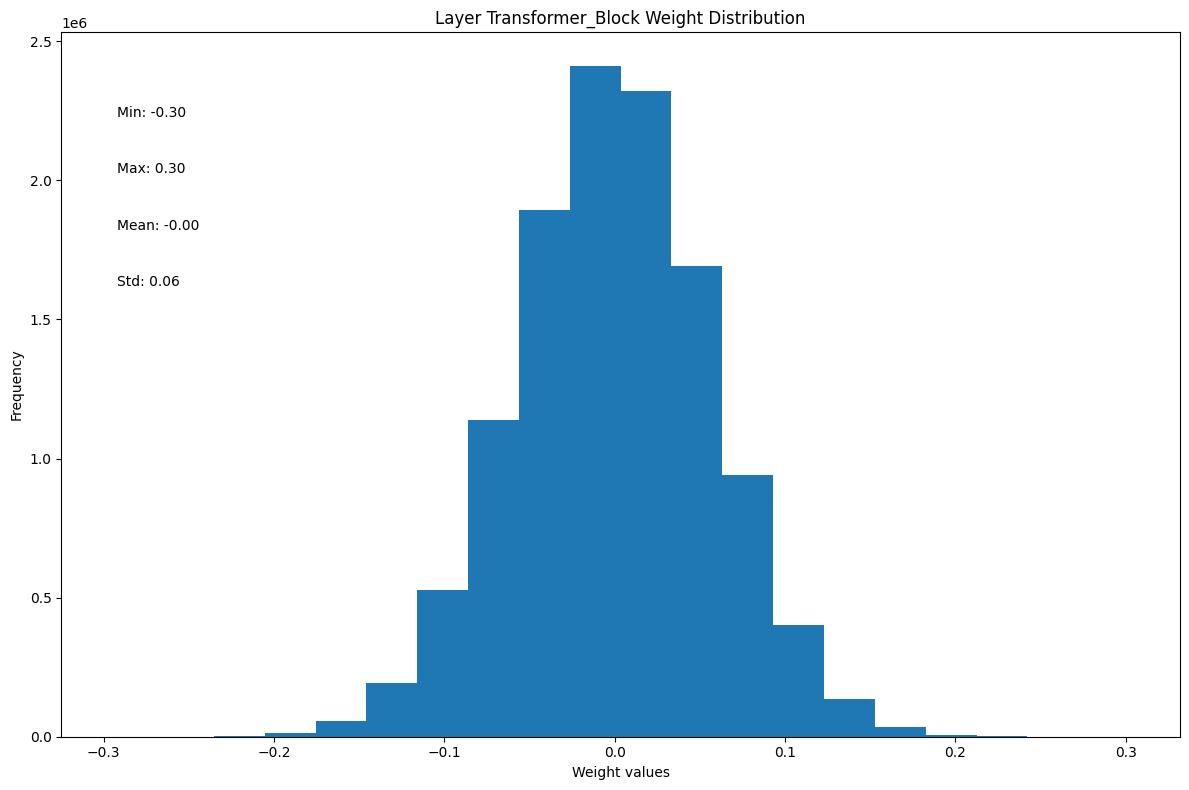

In [ ]:
def visualize_layer_weights(layer):
    """Visualize weights of the provided layer."""

    # Get the weights of the specified layer
    weights = layer.get_weights()

    if len(weights) == 0:
        print(f'Layer {layer.name} has no weights to visualize.')
        return

    # Create a figure
    plt.figure(figsize=(12, 8))

    # Flatten the weights for visualization
    weight_values = weights[0].flatten()  # 0 index for main weight matrix

    # If weights are all zeros, print message and return
    if np.all(weight_values == 0):
        print(f'Weights for layer {layer.name} contain only zeros.')
        return

    # Plot histogram of weights
    plt.hist(weight_values, bins=20)
    plt.title('Layer ' + layer.name + ' Weight Distribution')
    plt.xlabel('Weight values')
    plt.ylabel('Frequency')

    # Compute statistics
    weight_min = np.min(weight_values)
    weight_max = np.max(weight_values)
    weight_mean = np.mean(weight_values)
    weight_std = np.std(weight_values)

    # Annotate statistics
    plt.annotate('Min: {:.2f}'.format(weight_min), xy=(0.05, 0.88), xycoords='axes fraction')
    plt.annotate('Max: {:.2f}'.format(weight_max), xy=(0.05, 0.80), xycoords='axes fraction')
    plt.annotate('Mean: {:.2f}'.format(weight_mean), xy=(0.05, 0.72), xycoords='axes fraction')
    plt.annotate('Std: {:.2f}'.format(weight_std), xy=(0.05, 0.64), xycoords='axes fraction')

    # Show the plot
    plt.tight_layout()
    plt.show()

model = t_model.model

visualize_layer_weights(model.layers[-1])

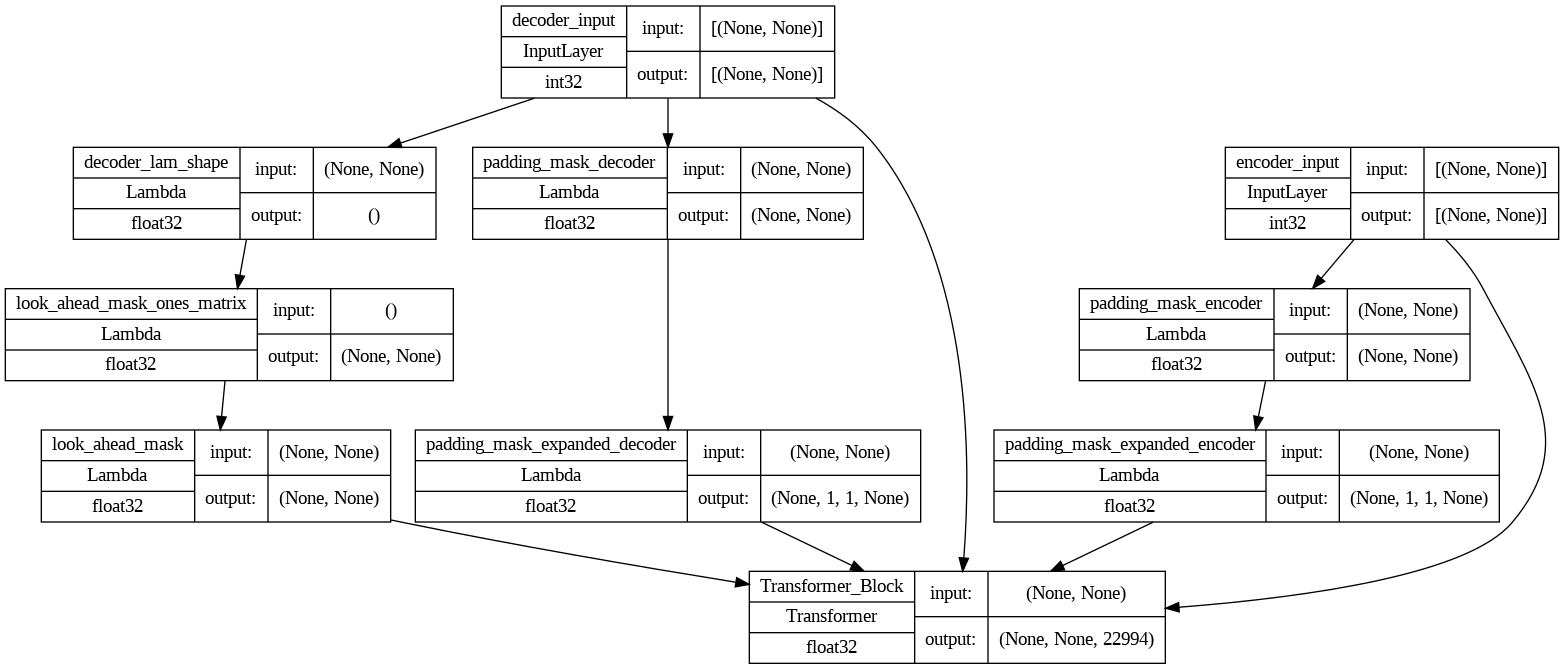

In [ ]:
model = t_model.model
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)


In [ ]:
class HistoryPlotter:
    def __init__(self, history):
        self.history = history

    def plot_loss(self):
        fig, ax = plt.subplots(figsize=(7, 5))
        ax.plot(self.history.history['loss'], label='Training loss')
        ax.plot(self.history.history['val_loss'], label='Validation loss')
        ax.set_title('Model loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.show()

    def plot_accuracy(self):
        fig, ax = plt.subplots(figsize=(7, 5))
        ax.plot(self.history.history['accuracy'], label='Training accuracy')
        ax.plot(self.history.history['val_accuracy'], label='Validation accuracy')
        ax.set_title('Model accuracy')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.legend()
        plt.show()



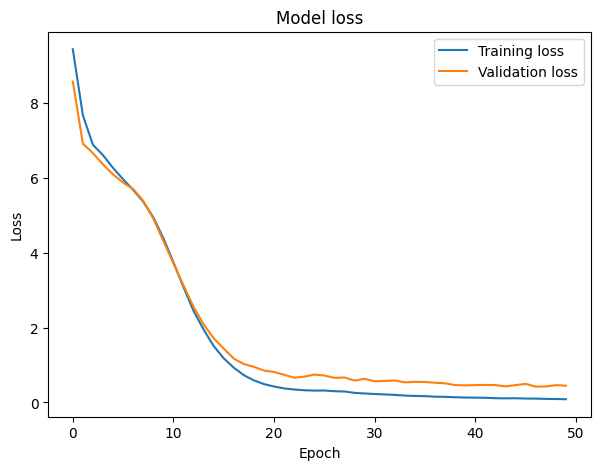

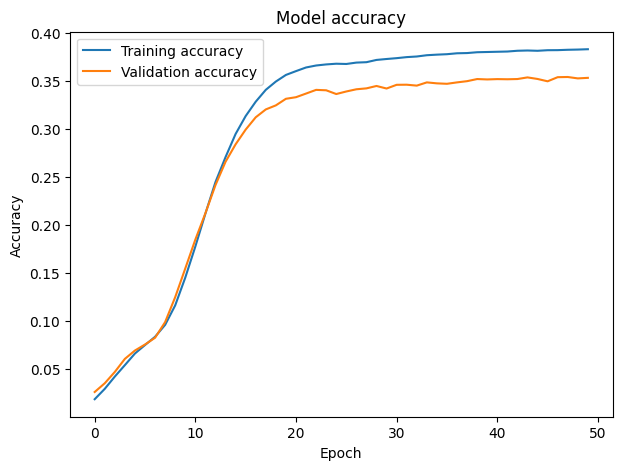

In [ ]:
# Plot the training history
plotter = HistoryPlotter(history)

# Plot the loss
plotter.plot_loss()

# Plot the accuracy
plotter.plot_accuracy()

## Saving the model:

In [ ]:
# Save the model
t_model.save('/content/drive/MyDrive/Colab Notebooks/Machine Learning/TensorFlow/Transformer/Transformer_Weight', data_proportion=preprocessing_config['data_proportion'])